In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random as rn
import matplotlib.cm as cm

In [ ]:

N_val = 4

num_unit_cells_vals = [8, 16, 32, 64]
num_init_cond_vals = [20000]
num_init_conds_per_group = [i//200 for i in num_init_cond_vals]

cmap = cm.get_cmap("Blues", len(num_unit_cells_vals)+5)

a_val = 0.68
a_val_name = str(a_val).replace(".", "p")

z_vals = [1.6, 1.7, 2.0]
z_val_names = [str(z_val).replace(".", "p") for z_val in z_vals]

z_final = 1.6
min_t_final = 32 * 2.0

data_parent_path = f"../data/spin_dists_per_time/N{N_val}/a{a_val_name}/IC1"

/var/folders/0k/n4x5z88x1rx124p1g1l55hmc0000gn/T/ipykernel_11980/3108770299.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Blues", len(num_unit_cells_vals)+5)


In [49]:
s_diffs_per_time = {} # L_val: {initcond: [s_diff(t)]}
s_errs_per_time = {}

for num_unit_cells in num_unit_cells_vals:
    L_val = num_unit_cells * N_val
    print(f"L = {L_val}")
    s_diffs_per_time[L_val] = {}
    s_errs_per_time[L_val] = {}

    current_loaded_data = []
    current_loaded_std = []
    current_loaded_group = []

    final_time = int(L_val ** z_final)
    
    list_of_sample_files = os.listdir(f"{data_parent_path}/L{L_val}")

    # Some L vals have to go further sometimes
    current_z_vals = [z_val for z_val in z_vals]
    if L_val < 128 and a_val >= 0.75:
         current_z_vals = [z_val for z_val in z_vals if z_val >= 2.0]
    current_z_val_names = [str(z_val).replace(".", "p") for z_val in current_z_vals]
    for i, sample_file in enumerate(list_of_sample_files):
        valid_sample = False
        for z_val_name in current_z_val_names:
            if z_val_name in sample_file:
                valid_sample = True
        if not valid_sample:
            continue
        
        sample_num = i+1

        sample_file_path = f"{data_parent_path}/L{L_val}/{sample_file}"
        df = pd.read_csv(sample_file_path)

        current_loaded_group.append(df.loc[:max(int(L_val ** z_final - 0.5), min_t_final), "delta_s"])

        if len(current_loaded_group) in num_init_conds_per_group:
            current_loaded_data.append(np.mean(np.array(current_loaded_group).T, axis=1))
            current_loaded_std.append(np.std(np.array(current_loaded_group).T, axis=1))
            current_loaded_group = []
        
        if sample_num in num_init_cond_vals:
            print(f"L = {L_val} | Reached {sample_num}/{max(num_init_cond_vals)} sample")
            s_diffs_per_time[L_val][sample_num] = np.median(np.array(current_loaded_data).T, axis=1)
            s_errs_per_time[L_val][sample_num] = np.std(np.array(current_loaded_data).T, axis=1) / np.sqrt(len(current_loaded_data)-1)
            if sample_num == max(num_init_cond_vals):
                print(f"L = {L_val} | Success: Made it to end - {sample_num}/{max(num_init_cond_vals)} sample")

L = 32
L = 32 | Reached 5000/5000 sample
L = 32 | Success: Made it to end - 5000/5000 sample
L = 64
L = 64 | Reached 5000/5000 sample
L = 64 | Success: Made it to end - 5000/5000 sample
L = 128
L = 128 | Reached 5000/5000 sample
L = 128 | Success: Made it to end - 5000/5000 sample
L = 256
L = 256 | Reached 5000/5000 sample
L = 256 | Success: Made it to end - 5000/5000 sample


In [56]:
x_range = 100
y_lims = (-20, 0)

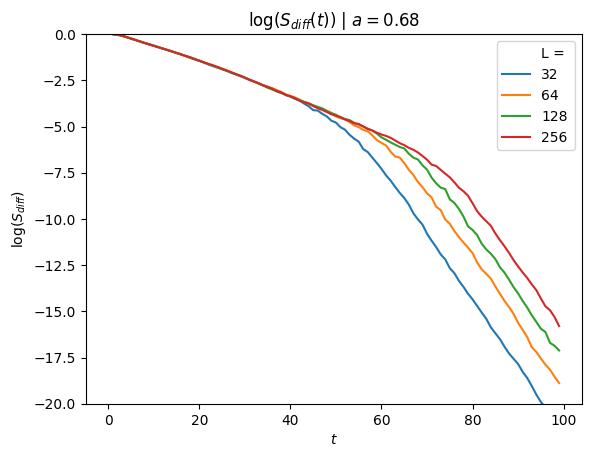

../figs/sdiff_vs_L/s_diff_vs_L_a0p68.png


In [57]:
plt.plot([], [], label = "L = ", c="w")
for num_unit_cells in num_unit_cells_vals:
    L_val = num_unit_cells * N_val
    y = np.log(np.array(s_diffs_per_time[L_val][num_init_cond_vals[0]]))
    plt.plot(np.array([i for i in range(0, min(x_range, len(y)))]), y[:x_range], label=f"{L_val}")

    plt.title(fr"$\log(S_{{diff}}(t))$ | $a={a_val}$")
    plt.xlabel(r"$t$")
    plt.ylabel(r"$\log(S_{diff})$")
    plt.legend()

plt.ylim(y_lims)
plt.savefig(f"../figs/sdiff_vs_L/s_diff_vs_L_a{a_val_name}.png")  
plt.show()
print(f"../figs/sdiff_vs_L/s_diff_vs_L_a{a_val_name}.png")

saved_plot: ../figs/sdiff_vs_L/aval_0p68.png


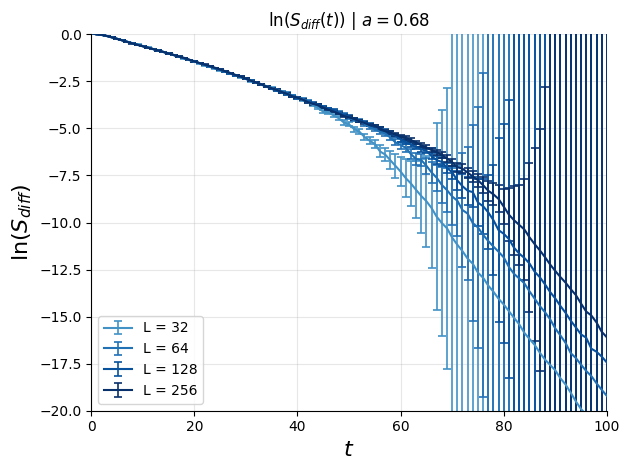

In [58]:
prop_const = 10
for j, num_unit_cells in enumerate(num_unit_cells_vals):
    L_val = num_unit_cells * N_val
    for i, num_init_conds in enumerate(num_init_cond_vals):
        c = cmap((j+5)/(len(num_unit_cells_vals)+5))
        # plt.axvline(prop_const * np.log(L_val * num_init_conds), color = c)

        y = np.log(np.array(s_diffs_per_time[L_val][num_init_conds]))
        y_errs = np.abs((1 / (np.array(s_diffs_per_time[L_val][num_init_conds]) + 1e-13)) * np.array(s_errs_per_time[L_val][num_init_conds]))
        xs = [k for k in range(0, len(y))]
        x_lim = int(L_val ** z_final)
        plt.errorbar(x=xs[:x_lim], y=y[:x_lim], yerr=y_errs[:x_lim],label=f"L = {L_val}",
                 color = c,
                 ecolor=c,         # same color for error bars
                    elinewidth=1.2,       # a bit thicker
                    capsize=3,            # small serif-like caps
                    capthick=1.2,)

    plt.title(fr"$\ln(S_{{diff}}(t))$ | $a={a_val}$")
    plt.xlabel(r"$t$", fontsize=16)
    plt.ylabel(r"$\ln(S_{diff})$", fontsize=16)
    plt.legend()
    
plt.ylim(y_lims)
plt.xlim(0, x_range)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"../figs/sdiff_vs_L/aval_{a_val_name}.png")  
print("saved_plot:", f"../figs/sdiff_vs_L/aval_{a_val_name}.png")
plt.show()

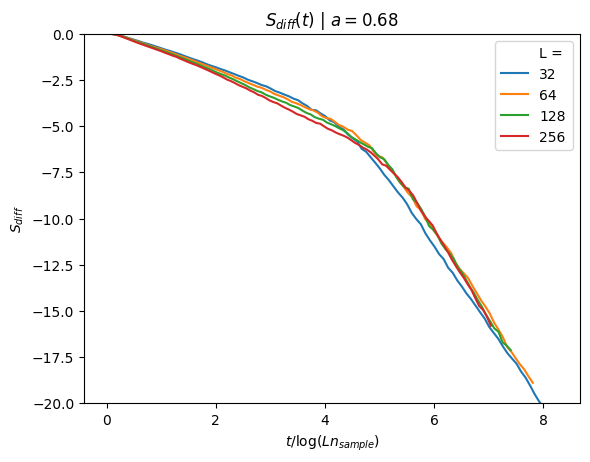

In [59]:
plt.plot([], [], label = "L = ", c="w")
for num_unit_cells in num_unit_cells_vals:
    L_val = num_unit_cells * N_val
    y = np.log(np.array(s_diffs_per_time[L_val][num_init_cond_vals[0]]))
    plt.plot(np.array([i for i in range(0, min(x_range, len(y)))])/np.log(L_val * num_init_cond_vals[0]), y[:x_range], label=f"{L_val}")

    plt.title(fr"$S_{{diff}}(t)$ | $a={a_val}$")
    plt.xlabel(r"$t/\log(L n_{sample})$")
    plt.ylabel(r"$S_{diff}$")
    plt.legend()

plt.ylim(y_lims)

plt.savefig(f"../figs/sdiff_vs_L/s_diff_vs_L_a{a_val}_collapse.png")  
plt.show()

saved_plot: ../figs/sdiff_vs_L/err_aval_0p68_collapse.png


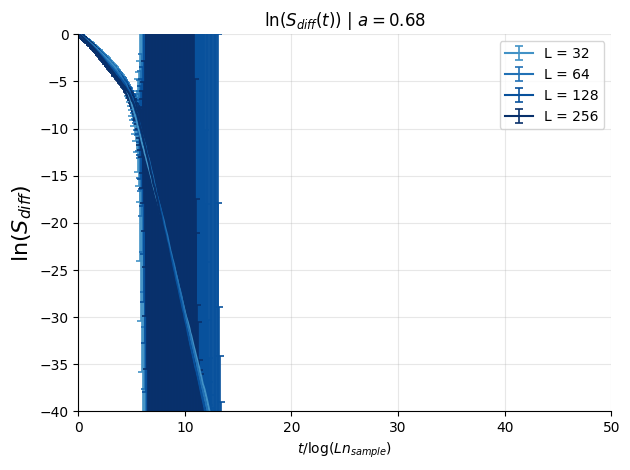

In [60]:
prop_const = 10
for j, num_unit_cells in enumerate(num_unit_cells_vals):
    L_val = num_unit_cells * N_val
    for i, num_init_conds in enumerate(num_init_cond_vals):
        c = cmap((j+5)/(len(num_unit_cells_vals)+5))
        # plt.axvline(prop_const * np.log(L_val * num_init_conds), color = c)

        y = np.log(np.array(s_diffs_per_time[L_val][num_init_conds]))
        y_errs = np.abs((1 / (np.array(s_diffs_per_time[L_val][num_init_conds]) + 1e-13)) * np.array(s_errs_per_time[L_val][num_init_conds]))
        xs = [k for k in range(0, len(y))]
        x_lim = int(L_val ** z_final)
        plt.errorbar(x=np.array(xs[:x_lim])/np.log(L_val * num_init_cond_vals[0]), y=y[:x_lim], yerr=y_errs[:x_lim],label=f"L = {L_val}",
                 color = c,
                 ecolor=c,         # same color for error bars
                    elinewidth=1.2,       # a bit thicker
                    capsize=3,            # small serif-like caps
                    capthick=1.2,)

    plt.title(fr"$\ln(S_{{diff}}(t))$ | $a={a_val}$")
    plt.xlabel(r"$t/\log(L n_{sample})$")
    plt.ylabel(r"$\ln(S_{diff})$", fontsize=16)
    plt.legend()
    
plt.ylim(-40, 0)
plt.xlim(0, 50)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"../figs/sdiff_vs_L/aval_{a_val_name}_collapse.png")  
print("saved_plot:", f"../figs/sdiff_vs_L/err_aval_{a_val_name}_collapse.png")
plt.show()

In [61]:
1/np.log(np.array(num_unit_cells_vals)*4 * 1000)

array([0.09639956, 0.09036168, 0.08503556, 0.08030237])